In [1]:
import re
import sys
from time import sleep
from pprint import pprint
from functools import partial

import numpy as np
import optuna
try:
    import pandas as pd
except:
    pass


FILENAME = "main.cpp"

In [2]:
#!cp ../exp012_Dlarge_M2/main.cpp ./

In [3]:
!g++ {FILENAME} -std=gnu++17 -Wall -Wextra -O2 -DONLINE_JUDGE -o {FILENAME}.out

main.cpp:458: warning: ignoring #pragma warning  [-Wunknown-pragmas]
  458 | #pragma warning( disable : 4146 )
      | 
main.cpp: In member function ‘void UltimateEstimator::Step()’:
main.cpp:1149:39: warning: comparison of integer expressions of different signedness: ‘signed char’ and ‘std::array<double, 60>::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
 1149 |   for (auto col = (signed char)0; col < data_x.size(); col++) {
      |                                   ~~~~^~~~~~~~~~~~~~~
main.cpp:1107:8: warning: unused variable ‘estimated_distance’ [-Wunused-variable]
 1107 |   auto estimated_distance = 0.0;
      |        ^~~~~~~~~~~~~~~~~~
main.cpp: In member function ‘void Explorer::Step()’:
main.cpp:1465:30: warning: narrowing conversion of ‘(((int)v.Explorer::Node::y) + 1)’ from ‘int’ to ‘signed char’ [-Wnarrowing]
 1465 |     const auto u = Node{ v.y + (i8)1, v.x, false };
      |                          ~~~~^~~~~~~
main.cpp:1478:35: warning: narrowing conversion of ‘(((

In [4]:
%%time
# もとのスコアの確認
scores = []
for i in range(200):
    i = f"{i:03d}"
    score = !cargo run --release --manifest-path ../tools/Cargo.toml --bin tester in/{i}.txt $(pwd)/{FILENAME}.out 2>&1 | grep Score
    print(i, *score)
    score = int(score[0].split()[-1])
    scores.append(score)
np.mean(scores) / 1e6, np.std(scores) / 1e6

000 Score = 982241200
001 Score = 979815594
002 Score = 972276792
003 Score = 985830545
004 Score = 982263046
005 Score = 979761219
006 Score = 981247034
007 Score = 979892306
008 Score = 984277601
009 Score = 985835545
010 Score = 983204361
011 Score = 980572205
012 Score = 983250094
013 Score = 985113387
014 Score = 971537788
015 Score = 983989077
016 Score = 980302679
017 Score = 985006151
018 Score = 980384316
019 Score = 984070301
020 Score = 981651398
021 Score = 984532959
022 Score = 984345023
023 Score = 982367324
024 Score = 972351045
025 Score = 984318448
026 Score = 983530669
027 Score = 981539224
028 Score = 981236650
029 Score = 978789647
030 Score = 983596513
031 Score = 982064295
032 Score = 983056495
033 Score = 976397903
034 Score = 982828522
035 Score = 988157807
036 Score = 984379869
037 Score = 976924322
038 Score = 983398253
039 Score = 984068583
040 Score = 982218397
041 Score = 983892656
042 Score = 979864313
043 Score = 983827367
044 Score = 981417977
045 Score 

(981.11938437, 4.453494955858767)

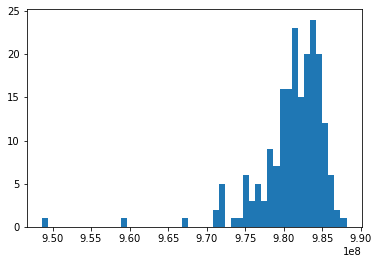

In [5]:
import matplotlib.pyplot as plt
plt.hist(scores, bins=50)
plt.show()

In [2]:
# ここでエラー出力は何かおかしいかもしれない


# パラメータ抽出
with open(FILENAME) as f:
    answer = f.read()


variables_optimize = []

for left, value, right, options in re.findall(r"^([^/\n]*=\s*)(.+?)(\s*;\s*//(?:.*\W)?OPTIMIZE(\W.*))$", answer, re.MULTILINE):
    name = left.replace("=", "").strip().split()[-1]
    
    searched = re.search(r".*\[(?P<min>.*),(?P<max>.*)\].*", options)
    if searched:
        min_value = max_value = None
        try:
            min_value = eval(searched.group("min"))
            max_value = eval(searched.group("max"))
            assert min_value <= max_value
        except Exception as e:
            print(f"searched={searched}", file=sys.stderr)
            print(e, file=sys.stderr)
            continue
        log = "LOG" in options  # 雑、直したほうが良い
        if type(min_value) != type(max_value):
            print(f"searched={searched}", file=sys.stderr)
            print("types not matched", file=sys.stderr)
            continue
        if isinstance(min_value, int):
            method = "suggest_int"
        elif isinstance(min_value, float):
            method = "suggest_float"
        else:
            print(f"searched={searched}", file=sys.stderr)
            print(f"unknown type ({type(min_value)})", file=sys.stderr)
            continue
        variables_optimize.append({
            "name": name,
            "method": method,
            "min": min_value,
            "max": max_value,
            "log": log,
            "left": left,
            "right": right,
        })
    elif searched := re.search(r".*\{(?P<choices>.*?)\}.*", options):
        choices = list(map(lambda x: x.strip(), searched.group("choices").split(",")))
        variables_optimize.append({
            "name": name,
            "method": "suggest_categorical",
            "choices": choices,
            "left": left,
            "right": right,
        })
    else:
        print(f"searched={searched}", file=sys.stderr)
        print(f"pattern was matched but options are incorrect.", file=sys.stderr)

print(len(variables_optimize), "variables were found.")
if globals().get("pd"):
    display(pd.DataFrame(variables_optimize))
else:
    pprint(variables_optimize)

3 variables were found.


,name,method,min,max,log,left,right
0,LAMBDA,suggest_float,2.0,10000.0,True,constexpr double LAMBDA =,"; // OPTIMIZE [2.0, 1e4] LOG"
1,LASSO_LAMBDA,suggest_float,1000.0,1000000.0,True,constexpr double LASSO_LAMBDA =,"; // OPTIMIZE [1e3, 1e6] LOG"
2,RIDGE2_LAMBDA,suggest_float,1.0,10000000.0,True,constexpr double RIDGE2_LAMBDA =,"; // OPTIMIZE [1.0, 1e7] LOG"


In [3]:
def escape(string):  # 正規表現の中でそのまま使いたい文字列をエスケープ
    res = !echo '{string}' | sed -e 's/[]\/$*.^[]/\\&/g'
    return res[0]

def escape_sed(string):  # sed の置換後の文字列用のエスケープ
    res = !echo '{string}' | sed -e 's/[\/&]/\\&/g'
    return res[0]


def objective_with_index(trial, n_internal_parallel):
    index_parallel = trial.number % 10  # これ変数にする
    print(f"{index_parallel=}")
    
    parameters_changed_filename = f"{index_parallel}_{FILENAME}"
    directory_input = "./in"  # "/" をつけない  # 中のすべてのファイルに対して実行される
    
    !mkdir {index_parallel}_out
    !mkdir {index_parallel}_score
    !rm {index_parallel}_out/*
    !rm {index_parallel}_score/*
    
    # ファイル作成
    !cp {FILENAME} {parameters_changed_filename}
    sed_options = [f"-i {parameters_changed_filename}"]
    for variable in variables_optimize:
        if variable["method"] == "suggest_categorical":
            val =  trial.suggest_categorical(variable["name"], variable["choices"])
        else:
            val = getattr(trial, variable["method"])(variable["name"], variable["min"], variable["max"], log=variable["log"])
        left = variable["left"]
        right = variable["right"]
        sed_options.append(f"""-e 's/^{escape(left)}.*{escape(right)}$/{escape_sed(left)}{val}{escape_sed(right)}/'""")
    command_sed = f"sed {' '.join(sed_options)}"
    print(command_sed)
    !{command_sed}
    
    # コンパイル
    command_compile = f"g++ {parameters_changed_filename} -std=gnu++17 -O2 -DONLINE_JUDGE -o {parameters_changed_filename}.out 2> /dev/null"
    print(command_compile)
    !{command_compile}
    # 実行・採点コマンド (@ はファイル名)
    command_exec = (
        f"cargo run --release --manifest-path ../tools/Cargo.toml --bin tester {directory_input}/@ $(pwd)/{parameters_changed_filename}.out 2>&1 | grep Score | sed -E s/[^0-9]+// > ./{index_parallel}_score/@;"
        #f"./{parameters_changed_filename}.out < {directory_input}/@ > ./{index_parallel}_out/@;"
        #f"cargo run --release --manifest-path ./tools/Cargo.toml --bin vis {directory_input}/@ ./{index_parallel}_out/@ 2> /dev/null > ./{index_parallel}_score/@;"
    )
    # 並列実行 (sed はパスのディレクトリ部分を消してファイル名にしてる)
    !find {directory_input}/* | sed 's!^.*/!!' | xargs -I@ -P {n_internal_parallel} sh -c '{command_exec}'
    
    # 集計
    file_paths = !find ./{index_parallel}_score/*
    sum_score = 0
    for file_path in file_paths:  
        with open(file_path) as f:
            sum_score += int(f.read())
    return sum_score

In [4]:
storage_path = f"study.db"
storage = f"sqlite:///{storage_path}"
study_name = "study"
study = optuna.create_study(storage=storage, load_if_exists=True, study_name=study_name, direction="maximize")

def callback(study, trial):
    try:
        if study.best_value == trial.value:
            print(f"Updated! {study.best_value}")
            index_parallel = trial.number % 10
            parameters_changed_filename = f"{index_parallel}_{FILENAME}"
            !cp {parameters_changed_filename} 00000optimized.cpp
        print("callback ok")
    except:
        print(":(")

objective = partial(objective_with_index, n_internal_parallel=4)
study.optimize(objective, n_trials=3000, timeout=86400, n_jobs=2, callbacks=[callback])

[I 2021-05-30 02:27:19,982] Using an existing study with name 'study' instead of creating a new one.
/home/nagis/anaconda3/lib/python3.8/site-packages/optuna/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(


index_parallel=1
index_parallel=2
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.722548232140944;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 212830.55805336914;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 79.81342026729475;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/cons

[I 2021-05-30 02:29:09,384] Trial 272 finished with value: 196933410351.0 and parameters: {'LAMBDA': 6.722548232140944, 'LASSO_LAMBDA': 212830.55805336914, 'RIDGE2_LAMBDA': 79.81342026729475}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists


[I 2021-05-30 02:29:09,517] Trial 271 finished with value: 196919971642.0 and parameters: {'LAMBDA': 6.728054135266627, 'LASSO_LAMBDA': 206215.03158159278, 'RIDGE2_LAMBDA': 90.44411851279128}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
rm: cannot remove '4_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.17071171857884;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 236221.51385679792;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 77.74524322862017;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.9242208140292565;           \/\/ O

[I 2021-05-30 02:30:53,782] Trial 274 finished with value: 196909612480.0 and parameters: {'LAMBDA': 5.9242208140292565, 'LASSO_LAMBDA': 186438.97320990422, 'RIDGE2_LAMBDA': 78.09527771718372}. Best is trial 246 with value: 196953744607.0.
[I 2021-05-30 02:30:53,800] Trial 273 finished with value: 196492745273.0 and parameters: {'LAMBDA': 5.17071171857884, 'LASSO_LAMBDA': 236221.51385679792, 'RIDGE2_LAMBDA': 77.74524322862017}. Best is trial 246 with value: 196953744607.0.


callback ok
callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
rm: cannot remove '6_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 3.9312853574221225;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 219562.37796905442;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 229.4610597108176;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZ

[I 2021-05-30 02:32:28,756] Trial 276 finished with value: 196920580576.0 and parameters: {'LAMBDA': 7.795730649081099, 'LASSO_LAMBDA': 220686.28409984597, 'RIDGE2_LAMBDA': 47.60075546576603}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory


[I 2021-05-30 02:32:29,754] Trial 275 finished with value: 196529676775.0 and parameters: {'LAMBDA': 3.9312853574221225, 'LASSO_LAMBDA': 219562.37796905442, 'RIDGE2_LAMBDA': 229.4610597108176}. Best is trial 246 with value: 196953744607.0.


callback ok
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.49906457274347;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 282007.44249303464;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 105.19181378622461;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.826763892937135;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/

[I 2021-05-30 02:34:03,873] Trial 277 finished with value: 196757763853.0 and parameters: {'LAMBDA': 4.49906457274347, 'LASSO_LAMBDA': 282007.44249303464, 'RIDGE2_LAMBDA': 105.19181378622461}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.863999256139453;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 162174.11695232015;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 70.85416068871535;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:34:05,565] Trial 278 finished with value: 196925384613.0 and parameters: {'LAMBDA': 6.826763892937135, 'LASSO_LAMBDA': 157482.95398605298, 'RIDGE2_LAMBDA': 106.89551460449951}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.742254512810373;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 121102.23218116879;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 23.356648055663655;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:35:43,162] Trial 279 finished with value: 196914285710.0 and parameters: {'LAMBDA': 6.863999256139453, 'LASSO_LAMBDA': 162174.11695232015, 'RIDGE2_LAMBDA': 70.85416068871535}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.97385896679227;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 125031.98732046442;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 24.686717633646598;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:35:44,870] Trial 280 finished with value: 196777614553.0 and parameters: {'LAMBDA': 8.742254512810373, 'LASSO_LAMBDA': 121102.23218116879, 'RIDGE2_LAMBDA': 23.356648055663655}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.317274521612742;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 103781.06219211638;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 200.1063198892403;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:37:19,205] Trial 281 finished with value: 196775646537.0 and parameters: {'LAMBDA': 8.97385896679227, 'LASSO_LAMBDA': 125031.98732046442, 'RIDGE2_LAMBDA': 24.686717633646598}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.545661921951016;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 108515.31259207556;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 200.1541546954739;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 02:37:20,936] Trial 282 finished with value: 196916812815.0 and parameters: {'LAMBDA': 8.317274521612742, 'LASSO_LAMBDA': 103781.06219211638, 'RIDGE2_LAMBDA': 200.1063198892403}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.651396535311737;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 137578.73655800588;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 137.0371928551746;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 02:38:54,973] Trial 283 finished with value: 196843610527.0 and parameters: {'LAMBDA': 5.545661921951016, 'LASSO_LAMBDA': 108515.31259207556, 'RIDGE2_LAMBDA': 200.1541546954739}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.609462553680702;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 134241.67021038017;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 127.45459506573229;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 02:38:56,559] Trial 284 finished with value: 196916792255.0 and parameters: {'LAMBDA': 5.651396535311737, 'LASSO_LAMBDA': 137578.73655800588, 'RIDGE2_LAMBDA': 137.0371928551746}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 15.016491141967025;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 14354.975382030952;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 54.21101358676064;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 02:40:29,479] Trial 285 finished with value: 196917709039.0 and parameters: {'LAMBDA': 10.609462553680702, 'LASSO_LAMBDA': 134241.67021038017, 'RIDGE2_LAMBDA': 127.45459506573229}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.171296004521531;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 189785.09105709568;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 58.85153898521066;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 02:40:34,111] Trial 286 finished with value: 196406725231.0 and parameters: {'LAMBDA': 15.016491141967025, 'LASSO_LAMBDA': 14354.975382030952, 'RIDGE2_LAMBDA': 54.21101358676064}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.4352704325628;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 187702.26874790768;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 78.68127669732772;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 02:42:04,176] Trial 287 finished with value: 196862442279.0 and parameters: {'LAMBDA': 14.171296004521531, 'LASSO_LAMBDA': 189785.09105709568, 'RIDGE2_LAMBDA': 58.85153898521066}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.384127222892204;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 165476.44308086394;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 87.9295438783354;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:42:09,352] Trial 288 finished with value: 196937700173.0 and parameters: {'LAMBDA': 7.4352704325628, 'LASSO_LAMBDA': 187702.26874790768, 'RIDGE2_LAMBDA': 78.68127669732772}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.718220820093694;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 170930.54099436157;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 82.40115169045399;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:43:40,519] Trial 289 finished with value: 196921241270.0 and parameters: {'LAMBDA': 7.384127222892204, 'LASSO_LAMBDA': 165476.44308086394, 'RIDGE2_LAMBDA': 87.9295438783354}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.937613587358587;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 267794.2678609223;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 38.71910598394511;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:43:45,772] Trial 290 finished with value: 196940512245.0 and parameters: {'LAMBDA': 7.718220820093694, 'LASSO_LAMBDA': 170930.54099436157, 'RIDGE2_LAMBDA': 82.40115169045399}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.3668364751709;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 205655.62404951;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 37.12492708120179;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:45:15,367] Trial 291 finished with value: 196877400231.0 and parameters: {'LAMBDA': 9.937613587358587, 'LASSO_LAMBDA': 267794.2678609223, 'RIDGE2_LAMBDA': 38.71910598394511}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.29439669528148;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 208025.44639611844;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 79.04917195176328;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 02:45:21,987] Trial 292 finished with value: 196864669027.0 and parameters: {'LAMBDA': 6.3668364751709, 'LASSO_LAMBDA': 205655.62404951, 'RIDGE2_LAMBDA': 37.12492708120179}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.007437631422627;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 174529.41341831686;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 80.8231625202787;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 02:46:49,933] Trial 293 finished with value: 196919596650.0 and parameters: {'LAMBDA': 6.29439669528148, 'LASSO_LAMBDA': 208025.44639611844, 'RIDGE2_LAMBDA': 79.04917195176328}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.800988049761739;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 327529.0361801569;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 64.53700146995466;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 02:46:56,539] Trial 294 finished with value: 196948842237.0 and parameters: {'LAMBDA': 8.007437631422627, 'LASSO_LAMBDA': 174529.41341831686, 'RIDGE2_LAMBDA': 80.8231625202787}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.4912375485537845;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 188112.9601128049;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 55.778011951793914;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 02:48:24,548] Trial 295 finished with value: 196940268941.0 and parameters: {'LAMBDA': 7.800988049761739, 'LASSO_LAMBDA': 327529.0361801569, 'RIDGE2_LAMBDA': 64.53700146995466}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.332265048050706;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 181892.27546758665;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 55.07753438170679;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 02:48:31,554] Trial 296 finished with value: 196907449443.0 and parameters: {'LAMBDA': 7.4912375485537845, 'LASSO_LAMBDA': 188112.9601128049, 'RIDGE2_LAMBDA': 55.778011951793914}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.598473782097239;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 305414.2043192456;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 47.17125354468981;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 02:49:59,308] Trial 297 finished with value: 196903682122.0 and parameters: {'LAMBDA': 10.332265048050706, 'LASSO_LAMBDA': 181892.27546758665, 'RIDGE2_LAMBDA': 55.07753438170679}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.198379347812331;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 444632.0493552462;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 76.46524479213316;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:50:06,022] Trial 298 finished with value: 196900131939.0 and parameters: {'LAMBDA': 10.598473782097239, 'LASSO_LAMBDA': 305414.2043192456, 'RIDGE2_LAMBDA': 47.17125354468981}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.597963134586477;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 398872.83739067795;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 72.6662450158169;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:51:32,745] Trial 299 finished with value: 196927509036.0 and parameters: {'LAMBDA': 9.198379347812331, 'LASSO_LAMBDA': 444632.0493552462, 'RIDGE2_LAMBDA': 76.46524479213316}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.772790135470108;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 146310.47414388703;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 103.01204988915785;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:51:39,556] Trial 300 finished with value: 196924481836.0 and parameters: {'LAMBDA': 8.597963134586477, 'LASSO_LAMBDA': 398872.83739067795, 'RIDGE2_LAMBDA': 72.6662450158169}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.154506358871932;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 164172.07300693486;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 98.22817998383228;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 02:53:08,171] Trial 301 finished with value: 196336969300.0 and parameters: {'LAMBDA': 4.772790135470108, 'LASSO_LAMBDA': 146310.47414388703, 'RIDGE2_LAMBDA': 103.01204988915785}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.850090966340538;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 165706.7952532635;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 100.52788949796691;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 02:53:14,761] Trial 302 finished with value: 196884538154.0 and parameters: {'LAMBDA': 5.154506358871932, 'LASSO_LAMBDA': 164172.07300693486, 'RIDGE2_LAMBDA': 98.22817998383228}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.594881707145513;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 169815.098608731;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 40.00503957985586;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 02:54:42,408] Trial 303 finished with value: 196895407406.0 and parameters: {'LAMBDA': 11.850090966340538, 'LASSO_LAMBDA': 165706.7952532635, 'RIDGE2_LAMBDA': 100.52788949796691}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.477657779820009;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 148867.48828353253;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 36.27267981444766;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 02:54:49,421] Trial 304 finished with value: 196837421083.0 and parameters: {'LAMBDA': 12.594881707145513, 'LASSO_LAMBDA': 169815.098608731, 'RIDGE2_LAMBDA': 40.00503957985586}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.83147101469277;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 140121.96532581825;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 61.71323659964351;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 02:56:16,715] Trial 305 finished with value: 196882010553.0 and parameters: {'LAMBDA': 7.477657779820009, 'LASSO_LAMBDA': 148867.48828353253, 'RIDGE2_LAMBDA': 36.27267981444766}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.305584339046955;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 245031.1006946012;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 64.33771126359953;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 02:56:25,399] Trial 306 finished with value: 196914074321.0 and parameters: {'LAMBDA': 7.83147101469277, 'LASSO_LAMBDA': 140121.96532581825, 'RIDGE2_LAMBDA': 61.71323659964351}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.525144579632274;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 379352.4087182499;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1.6340639769383942;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 02:57:52,331] Trial 307 finished with value: 196938945066.0 and parameters: {'LAMBDA': 8.305584339046955, 'LASSO_LAMBDA': 245031.1006946012, 'RIDGE2_LAMBDA': 64.33771126359953}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.070990338043835;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 558159.5279714308;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 66.54847857643094;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 02:58:01,516] Trial 308 finished with value: 194846120805.0 and parameters: {'LAMBDA': 6.525144579632274, 'LASSO_LAMBDA': 379352.4087182499, 'RIDGE2_LAMBDA': 1.6340639769383942}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.555109352218789;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 351628.1780653926;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 62.851146862050065;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 02:59:25,327] Trial 309 finished with value: 196872511457.0 and parameters: {'LAMBDA': 6.070990338043835, 'LASSO_LAMBDA': 558159.5279714308, 'RIDGE2_LAMBDA': 66.54847857643094}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.660001890187376;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 238561.5130912331;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 46.789224006391244;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 02:59:35,641] Trial 310 finished with value: 196903986352.0 and parameters: {'LAMBDA': 9.555109352218789, 'LASSO_LAMBDA': 351628.1780653926, 'RIDGE2_LAMBDA': 62.851146862050065}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.048725289603595;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 246332.9195702587;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 27.56454085962933;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:01:00,726] Trial 311 finished with value: 196911897452.0 and parameters: {'LAMBDA': 8.660001890187376, 'LASSO_LAMBDA': 238561.5130912331, 'RIDGE2_LAMBDA': 46.789224006391244}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.230482816086449;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 266631.8949220927;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 29.31011122099692;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:01:10,822] Trial 312 finished with value: 196845567778.0 and parameters: {'LAMBDA': 9.048725289603595, 'LASSO_LAMBDA': 246332.9195702587, 'RIDGE2_LAMBDA': 27.56454085962933}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.600768795316432;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 939485.2178400095;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 122.61467720021477;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:02:37,464] Trial 313 finished with value: 196845031794.0 and parameters: {'LAMBDA': 7.230482816086449, 'LASSO_LAMBDA': 266631.8949220927, 'RIDGE2_LAMBDA': 29.31011122099692}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.645731805594682;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 308445.29692160175;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 84.88279111758682;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:02:46,183] Trial 314 finished with value: 196903882757.0 and parameters: {'LAMBDA': 7.600768795316432, 'LASSO_LAMBDA': 939485.2178400095, 'RIDGE2_LAMBDA': 122.61467720021477}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.736751404581123;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 191234.176201149;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 85.08404336370735;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:04:12,025] Trial 315 finished with value: 196897132132.0 and parameters: {'LAMBDA': 10.645731805594682, 'LASSO_LAMBDA': 308445.29692160175, 'RIDGE2_LAMBDA': 84.88279111758682}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.5478061155746685;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 216812.66744193723;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 93.5650307089594;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:04:19,991] Trial 316 finished with value: 196924319215.0 and parameters: {'LAMBDA': 5.736751404581123, 'LASSO_LAMBDA': 191234.176201149, 'RIDGE2_LAMBDA': 85.08404336370735}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.805284824201633;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 320343.19235909416;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 114.1877953507521;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:05:46,890] Trial 317 finished with value: 196927895408.0 and parameters: {'LAMBDA': 5.5478061155746685, 'LASSO_LAMBDA': 216812.66744193723, 'RIDGE2_LAMBDA': 93.5650307089594}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.638159898786718;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 339148.7533972837;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 48.797237748304504;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:05:55,269] Trial 318 finished with value: 196911122885.0 and parameters: {'LAMBDA': 6.805284824201633, 'LASSO_LAMBDA': 320343.19235909416, 'RIDGE2_LAMBDA': 114.1877953507521}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.380284036557075;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 186745.39409086588;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 48.010046309383924;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:07:22,081] Trial 319 finished with value: 196904916809.0 and parameters: {'LAMBDA': 6.638159898786718, 'LASSO_LAMBDA': 339148.7533972837, 'RIDGE2_LAMBDA': 48.797237748304504}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.584576784946682;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 169839.89075861374;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 148.35689190195924;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:07:30,780] Trial 320 finished with value: 196899782871.0 and parameters: {'LAMBDA': 9.380284036557075, 'LASSO_LAMBDA': 186745.39409086588, 'RIDGE2_LAMBDA': 48.010046309383924}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.543529690556238;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 156849.53337841254;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 147.52664514498053;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:08:55,631] Trial 321 finished with value: 196911832661.0 and parameters: {'LAMBDA': 9.584576784946682, 'LASSO_LAMBDA': 169839.89075861374, 'RIDGE2_LAMBDA': 148.35689190195924}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.5146139233848475;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 256570.4478720222;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 68.0690335039066;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:09:05,169] Trial 322 finished with value: 196906447369.0 and parameters: {'LAMBDA': 4.543529690556238, 'LASSO_LAMBDA': 156849.53337841254, 'RIDGE2_LAMBDA': 147.52664514498053}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.993604709709971;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 232078.411841852;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 63.47877420652911;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:10:31,692] Trial 323 finished with value: 196265289333.0 and parameters: {'LAMBDA': 4.5146139233848475, 'LASSO_LAMBDA': 256570.4478720222, 'RIDGE2_LAMBDA': 68.0690335039066}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.614040249668598;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 135576.95517497795;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 67.29702711934507;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:10:41,643] Trial 324 finished with value: 196936935929.0 and parameters: {'LAMBDA': 7.993604709709971, 'LASSO_LAMBDA': 232078.411841852, 'RIDGE2_LAMBDA': 63.47877420652911}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.872828097884568;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 197888.18290689192;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 121.67733474641271;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:12:23,124] Trial 325 finished with value: 196903401925.0 and parameters: {'LAMBDA': 11.614040249668598, 'LASSO_LAMBDA': 135576.95517497795, 'RIDGE2_LAMBDA': 67.29702711934507}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.774021822684485;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 212269.74679127452;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 104.07406036785261;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:12:29,779] Trial 326 finished with value: 196941422588.0 and parameters: {'LAMBDA': 7.872828097884568, 'LASSO_LAMBDA': 197888.18290689192, 'RIDGE2_LAMBDA': 121.67733474641271}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.860248980322548;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 151031.38294969103;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 111.72605329176892;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:14:09,710] Trial 327 finished with value: 196939771375.0 and parameters: {'LAMBDA': 7.774021822684485, 'LASSO_LAMBDA': 212269.74679127452, 'RIDGE2_LAMBDA': 104.07406036785261}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.76906233481409;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 194458.9621097419;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 163.22696863997416;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:14:17,158] Trial 328 finished with value: 196932976023.0 and parameters: {'LAMBDA': 7.860248980322548, 'LASSO_LAMBDA': 151031.38294969103, 'RIDGE2_LAMBDA': 111.72605329176892}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.751731547821931;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 191010.79178306693;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 172.02145540117957;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:15:56,133] Trial 329 finished with value: 196924316861.0 and parameters: {'LAMBDA': 7.76906233481409, 'LASSO_LAMBDA': 194458.9621097419, 'RIDGE2_LAMBDA': 163.22696863997416}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.44669052185382;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 95752.77830034938;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 120.81655349063809;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:16:03,363] Trial 330 finished with value: 196892723713.0 and parameters: {'LAMBDA': 10.751731547821931, 'LASSO_LAMBDA': 191010.79178306693, 'RIDGE2_LAMBDA': 172.02145540117957}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 45.29146955749639;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 125597.54948332842;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 17.96179350930586;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:17:37,161] Trial 331 finished with value: 196898414638.0 and parameters: {'LAMBDA': 11.44669052185382, 'LASSO_LAMBDA': 95752.77830034938, 'RIDGE2_LAMBDA': 120.81655349063809}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.895514173380602;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 261778.4994930278;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 87.74875405964853;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:17:42,225] Trial 332 finished with value: 196065709053.0 and parameters: {'LAMBDA': 45.29146955749639, 'LASSO_LAMBDA': 125597.54948332842, 'RIDGE2_LAMBDA': 17.96179350930586}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.512909393087223;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 215534.96321736329;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 87.19455180447186;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:19:13,079] Trial 333 finished with value: 196926927461.0 and parameters: {'LAMBDA': 5.895514173380602, 'LASSO_LAMBDA': 261778.4994930278, 'RIDGE2_LAMBDA': 87.74875405964853}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.526753873400459;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 225008.83148530903;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 42.78934297987337;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:19:18,484] Trial 334 finished with value: 196915712001.0 and parameters: {'LAMBDA': 5.512909393087223, 'LASSO_LAMBDA': 215534.96321736329, 'RIDGE2_LAMBDA': 87.19455180447186}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.81163395761152;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 136491.46582870354;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 42.14779638524868;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:20:50,151] Trial 335 finished with value: 196852658911.0 and parameters: {'LAMBDA': 13.526753873400459, 'LASSO_LAMBDA': 225008.83148530903, 'RIDGE2_LAMBDA': 42.78934297987337}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.674365261759517;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 135713.2927489124;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 132.1332600108677;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:20:55,348] Trial 336 finished with value: 196879510151.0 and parameters: {'LAMBDA': 8.81163395761152, 'LASSO_LAMBDA': 136491.46582870354, 'RIDGE2_LAMBDA': 42.14779638524868}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.240669874943854;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 120406.1980371823;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 136.02383546937506;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:22:26,478] Trial 337 finished with value: 196932655097.0 and parameters: {'LAMBDA': 8.674365261759517, 'LASSO_LAMBDA': 135713.2927489124, 'RIDGE2_LAMBDA': 132.1332600108677}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.105247528941014;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 113870.53926627514;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 55.59701991082228;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:22:31,324] Trial 338 finished with value: 196949644076.0 and parameters: {'LAMBDA': 7.240669874943854, 'LASSO_LAMBDA': 120406.1980371823, 'RIDGE2_LAMBDA': 136.02383546937506}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.754329287026814;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 115263.2608545403;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 186.74904000439088;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:24:04,093] Trial 339 finished with value: 196899955670.0 and parameters: {'LAMBDA': 7.105247528941014, 'LASSO_LAMBDA': 113870.53926627514, 'RIDGE2_LAMBDA': 55.59701991082228}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.322324754188714;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 94599.54273324343;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 180.77230464376152;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:24:08,984] Trial 340 finished with value: 196878287008.0 and parameters: {'LAMBDA': 6.754329287026814, 'LASSO_LAMBDA': 115263.2608545403, 'RIDGE2_LAMBDA': 186.74904000439088}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 3.7038500881621363;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 94166.26760689793;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 73.67603342241027;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:25:42,027] Trial 341 finished with value: 196913346943.0 and parameters: {'LAMBDA': 6.322324754188714, 'LASSO_LAMBDA': 94599.54273324343, 'RIDGE2_LAMBDA': 180.77230464376152}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.256304547115372;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 284749.8233849827;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 74.67129024306442;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:25:47,225] Trial 342 finished with value: 196094480465.0 and parameters: {'LAMBDA': 3.7038500881621363, 'LASSO_LAMBDA': 94166.26760689793, 'RIDGE2_LAMBDA': 73.67603342241027}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9550.317656012525;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 124906.11594318016;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 114.73910393935732;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:27:19,660] Trial 343 finished with value: 196857098590.0 and parameters: {'LAMBDA': 5.256304547115372, 'LASSO_LAMBDA': 284749.8233849827, 'RIDGE2_LAMBDA': 74.67129024306442}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.982787554459442;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 451974.6838093181;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31.633844381377653;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:27:26,065] Trial 344 finished with value: 193376628197.0 and parameters: {'LAMBDA': 9550.317656012525, 'LASSO_LAMBDA': 124906.11594318016, 'RIDGE2_LAMBDA': 114.73910393935732}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.08715098408367;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 179800.01610440304;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 29.21779577895344;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:29:00,870] Trial 345 finished with value: 196853856045.0 and parameters: {'LAMBDA': 9.982787554459442, 'LASSO_LAMBDA': 451974.6838093181, 'RIDGE2_LAMBDA': 31.633844381377653}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.10067245291229;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 180608.4758295354;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 57.17248737470502;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:29:07,689] Trial 346 finished with value: 196838462386.0 and parameters: {'LAMBDA': 10.08715098408367, 'LASSO_LAMBDA': 179800.01610440304, 'RIDGE2_LAMBDA': 29.21779577895344}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.6535490161207544;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 103839.93445840369;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 144.26225125860717;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:30:50,499] Trial 347 finished with value: 196919273006.0 and parameters: {'LAMBDA': 7.10067245291229, 'LASSO_LAMBDA': 180608.4758295354, 'RIDGE2_LAMBDA': 57.17248737470502}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.873063314372475;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 108142.60096549481;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 147.6847244147867;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:30:55,673] Trial 348 finished with value: 196935110072.0 and parameters: {'LAMBDA': 7.6535490161207544, 'LASSO_LAMBDA': 103839.93445840369, 'RIDGE2_LAMBDA': 144.26225125860717}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.731627955932746;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 1162.0393281633308;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 97.66562609132008;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:32:43,623] Trial 349 finished with value: 196932382249.0 and parameters: {'LAMBDA': 7.873063314372475, 'LASSO_LAMBDA': 108142.60096549481, 'RIDGE2_LAMBDA': 147.6847244147867}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.396968832409706;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 142017.87982445958;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 93.5092530098865;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:34:03,168] Trial 350 finished with value: 130736801029.0 and parameters: {'LAMBDA': 5.731627955932746, 'LASSO_LAMBDA': 1162.0393281633308, 'RIDGE2_LAMBDA': 97.66562609132008}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.281833703746922;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 151779.31899463956;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 256.05289088181104;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:34:33,759] Trial 351 finished with value: 196905171196.0 and parameters: {'LAMBDA': 6.396968832409706, 'LASSO_LAMBDA': 142017.87982445958, 'RIDGE2_LAMBDA': 93.5092530098865}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 16.87596883463619;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 120017.06599395652;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 62.446699290198865;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:35:55,649] Trial 352 finished with value: 196888850314.0 and parameters: {'LAMBDA': 6.281833703746922, 'LASSO_LAMBDA': 151779.31899463956, 'RIDGE2_LAMBDA': 256.05289088181104}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 17.064453952480115;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 116847.30888142588;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 60.936838192808224;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:36:22,322] Trial 353 finished with value: 196809710404.0 and parameters: {'LAMBDA': 16.87596883463619, 'LASSO_LAMBDA': 120017.06599395652, 'RIDGE2_LAMBDA': 62.446699290198865}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.946917508791836;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 250671.96568640444;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 96.73013564902882;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:37:35,136] Trial 354 finished with value: 196797367913.0 and parameters: {'LAMBDA': 17.064453952480115, 'LASSO_LAMBDA': 116847.30888142588, 'RIDGE2_LAMBDA': 60.936838192808224}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.98994511959894;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 244225.06246969092;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 96.71963252191415;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:38:02,490] Trial 355 finished with value: 196930618776.0 and parameters: {'LAMBDA': 8.946917508791836, 'LASSO_LAMBDA': 250671.96568640444, 'RIDGE2_LAMBDA': 96.73013564902882}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.439254254409951;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 208872.7529572616;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 180.27538284030933;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:39:11,129] Trial 356 finished with value: 196931218973.0 and parameters: {'LAMBDA': 8.98994511959894, 'LASSO_LAMBDA': 244225.06246969092, 'RIDGE2_LAMBDA': 96.71963252191415}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.756143735888463;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 194548.39152620596;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 178.31802248867146;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:39:38,053] Trial 357 finished with value: 196872286318.0 and parameters: {'LAMBDA': 12.439254254409951, 'LASSO_LAMBDA': 208872.7529572616, 'RIDGE2_LAMBDA': 180.27538284030933}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.187156770799015;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 159835.75115237778;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 43.851700739226914;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:40:45,549] Trial 358 finished with value: 196840196466.0 and parameters: {'LAMBDA': 13.756143735888463, 'LASSO_LAMBDA': 194548.39152620596, 'RIDGE2_LAMBDA': 178.31802248867146}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.94579641113309;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 88665.538404336;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 43.2180731068168;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:41:12,841] Trial 359 finished with value: 196848135027.0 and parameters: {'LAMBDA': 5.187156770799015, 'LASSO_LAMBDA': 159835.75115237778, 'RIDGE2_LAMBDA': 43.851700739226914}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.445242784671775;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 130817.66861080404;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 124.71836334833833;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:42:21,838] Trial 360 finished with value: 196281202337.0 and parameters: {'LAMBDA': 4.94579641113309, 'LASSO_LAMBDA': 88665.538404336, 'RIDGE2_LAMBDA': 43.2180731068168}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.72849900055111;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 132349.03655506676;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 130.99289488187463;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:42:46,655] Trial 361 finished with value: 196923899700.0 and parameters: {'LAMBDA': 7.445242784671775, 'LASSO_LAMBDA': 130817.66861080404, 'RIDGE2_LAMBDA': 124.71836334833833}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.764401867727607;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 103807.6045519224;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 73.48015446870517;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:43:55,380] Trial 362 finished with value: 196939064928.0 and parameters: {'LAMBDA': 7.72849900055111, 'LASSO_LAMBDA': 132349.03655506676, 'RIDGE2_LAMBDA': 130.99289488187463}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.702394308462067;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 170784.77753634562;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 70.9159346497918;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:44:21,327] Trial 363 finished with value: 196906632222.0 and parameters: {'LAMBDA': 10.764401867727607, 'LASSO_LAMBDA': 103807.6045519224, 'RIDGE2_LAMBDA': 73.48015446870517}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.345154703522173;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 172842.89664726477;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 243.6727574894821;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:45:29,284] Trial 364 finished with value: 196922207626.0 and parameters: {'LAMBDA': 10.702394308462067, 'LASSO_LAMBDA': 170784.77753634562, 'RIDGE2_LAMBDA': 70.9159346497918}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.2641886465141;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 144899.33061398703;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 10.485969810720215;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:45:57,098] Trial 365 finished with value: 196912972535.0 and parameters: {'LAMBDA': 7.345154703522173, 'LASSO_LAMBDA': 172842.89664726477, 'RIDGE2_LAMBDA': 243.6727574894821}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.469472914339934;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 669301.4435313722;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 116.99775429296668;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:47:05,514] Trial 366 finished with value: 196536381199.0 and parameters: {'LAMBDA': 7.2641886465141, 'LASSO_LAMBDA': 144899.33061398703, 'RIDGE2_LAMBDA': 10.485969810720215}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.254529542960372;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 288631.06133430905;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 123.4489302528443;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:47:31,273] Trial 367 finished with value: 196878846922.0 and parameters: {'LAMBDA': 6.469472914339934, 'LASSO_LAMBDA': 669301.4435313722, 'RIDGE2_LAMBDA': 116.99775429296668}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.10330965146045;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 142741.35371019854;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 103115.20692410813;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:48:39,615] Trial 368 finished with value: 196909798284.0 and parameters: {'LAMBDA': 6.254529542960372, 'LASSO_LAMBDA': 288631.06133430905, 'RIDGE2_LAMBDA': 123.4489302528443}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.683583684632291;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 135449.15882440863;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 55.01491188122298;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:49:04,993] Trial 369 finished with value: 196820943251.0 and parameters: {'LAMBDA': 9.10330965146045, 'LASSO_LAMBDA': 142741.35371019854, 'RIDGE2_LAMBDA': 103115.20692410813}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.152028499961453;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 209511.14956191057;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 59.6768191763941;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:50:14,348] Trial 370 finished with value: 196906710476.0 and parameters: {'LAMBDA': 8.683583684632291, 'LASSO_LAMBDA': 135449.15882440863, 'RIDGE2_LAMBDA': 55.01491188122298}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.464775461436782;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 204890.3251274746;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 80.77523435306709;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:50:40,159] Trial 371 finished with value: 196937708693.0 and parameters: {'LAMBDA': 8.152028499961453, 'LASSO_LAMBDA': 209511.14956191057, 'RIDGE2_LAMBDA': 59.6768191763941}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.479397275859034;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 220870.5891707288;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 37.46916146656082;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:51:49,869] Trial 372 finished with value: 196901760400.0 and parameters: {'LAMBDA': 5.464775461436782, 'LASSO_LAMBDA': 204890.3251274746, 'RIDGE2_LAMBDA': 80.77523435306709}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.332993030315622;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 91172.61252228312;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 36.70095556489059;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 03:52:17,636] Trial 373 finished with value: 196870858457.0 and parameters: {'LAMBDA': 5.479397275859034, 'LASSO_LAMBDA': 220870.5891707288, 'RIDGE2_LAMBDA': 37.46916146656082}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.856489335102228;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 93048.17019741746;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 217.00983016332015;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 03:53:26,687] Trial 374 finished with value: 196342079231.0 and parameters: {'LAMBDA': 4.332993030315622, 'LASSO_LAMBDA': 91172.61252228312, 'RIDGE2_LAMBDA': 36.70095556489059}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.87154326571959;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 122335.16687707789;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 215.72596370669402;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 03:53:51,159] Trial 375 finished with value: 196897535713.0 and parameters: {'LAMBDA': 9.856489335102228, 'LASSO_LAMBDA': 93048.17019741746, 'RIDGE2_LAMBDA': 217.00983016332015}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.619788254668289;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 116957.52946683276;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 53.7264691158822;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 03:55:00,801] Trial 376 finished with value: 196897791288.0 and parameters: {'LAMBDA': 9.87154326571959, 'LASSO_LAMBDA': 122335.16687707789, 'RIDGE2_LAMBDA': 215.72596370669402}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.841527051336252;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 340749.4366928747;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 94.00906719137835;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 03:55:25,686] Trial 377 finished with value: 196921132317.0 and parameters: {'LAMBDA': 7.619788254668289, 'LASSO_LAMBDA': 116957.52946683276, 'RIDGE2_LAMBDA': 53.7264691158822}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.629198580185536;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 318395.66586036904;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 93.85671083397514;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 03:56:35,523] Trial 378 finished with value: 196937151090.0 and parameters: {'LAMBDA': 7.841527051336252, 'LASSO_LAMBDA': 340749.4366928747, 'RIDGE2_LAMBDA': 94.00906719137835}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.123486386168297;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 462578.3046604794;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 135.21908756520602;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 03:57:00,155] Trial 379 finished with value: 196910971269.0 and parameters: {'LAMBDA': 6.629198580185536, 'LASSO_LAMBDA': 318395.66586036904, 'RIDGE2_LAMBDA': 93.85671083397514}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.672463891423494;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 362925.4318390274;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 153.76203647718395;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 03:58:10,850] Trial 380 finished with value: 196886547456.0 and parameters: {'LAMBDA': 12.123486386168297, 'LASSO_LAMBDA': 462578.3046604794, 'RIDGE2_LAMBDA': 135.21908756520602}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.332238698460277;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 377669.5426793283;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 149.46305531906665;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 03:58:34,792] Trial 381 finished with value: 196886762609.0 and parameters: {'LAMBDA': 11.672463891423494, 'LASSO_LAMBDA': 362925.4318390274, 'RIDGE2_LAMBDA': 153.76203647718395}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.534101322001483;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 326665.52860006643;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 339.389891139414;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 03:59:45,743] Trial 382 finished with value: 196942649223.0 and parameters: {'LAMBDA': 8.332238698460277, 'LASSO_LAMBDA': 377669.5426793283, 'RIDGE2_LAMBDA': 149.46305531906665}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.108188206415765;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 412349.517946256;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 272.08922847554607;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:00:09,603] Trial 383 finished with value: 196869983587.0 and parameters: {'LAMBDA': 8.534101322001483, 'LASSO_LAMBDA': 326665.52860006643, 'RIDGE2_LAMBDA': 339.389891139414}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.189526615518794;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 378681.2156767374;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 168.29100572263198;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:01:21,178] Trial 384 finished with value: 196878719512.0 and parameters: {'LAMBDA': 9.108188206415765, 'LASSO_LAMBDA': 412349.517946256, 'RIDGE2_LAMBDA': 272.08922847554607}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.246708463397128;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 155865.90366793252;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 1475211.9464944757;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:01:45,430] Trial 385 finished with value: 196867613426.0 and parameters: {'LAMBDA': 6.189526615518794, 'LASSO_LAMBDA': 378681.2156767374, 'RIDGE2_LAMBDA': 168.29100572263198}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.912134546039716;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 151907.0870316178;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 124.76353091681393;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:02:57,666] Trial 386 finished with value: 196815982587.0 and parameters: {'LAMBDA': 6.246708463397128, 'LASSO_LAMBDA': 155865.90366793252, 'RIDGE2_LAMBDA': 1475211.9464944757}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.088811910894135;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 103026.66777135034;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 119.18923929635604;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:03:21,891] Trial 387 finished with value: 196934555123.0 and parameters: {'LAMBDA': 6.912134546039716, 'LASSO_LAMBDA': 151907.0870316178, 'RIDGE2_LAMBDA': 124.76353091681393}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.374590468247428;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 132041.29404840062;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 171.11363307319385;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:04:31,286] Trial 388 finished with value: 196883830701.0 and parameters: {'LAMBDA': 10.088811910894135, 'LASSO_LAMBDA': 103026.66777135034, 'RIDGE2_LAMBDA': 119.18923929635604}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.707011846561682;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 132521.00032218627;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 181.94817511586726;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:04:57,774] Trial 389 finished with value: 196902770489.0 and parameters: {'LAMBDA': 10.374590468247428, 'LASSO_LAMBDA': 132041.29404840062, 'RIDGE2_LAMBDA': 171.11363307319385}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.702544591930281;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 79666.49770221423;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 89.26588274160946;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:06:08,253] Trial 390 finished with value: 196902664163.0 and parameters: {'LAMBDA': 4.707011846561682, 'LASSO_LAMBDA': 132521.00032218627, 'RIDGE2_LAMBDA': 181.94817511586726}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.873942581596047;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 80325.49149779968;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 85.00509336844023;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:06:34,520] Trial 391 finished with value: 196906961828.0 and parameters: {'LAMBDA': 7.702544591930281, 'LASSO_LAMBDA': 79666.49770221423, 'RIDGE2_LAMBDA': 89.26588274160946}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.676165400283013;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 516715.773390279;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 314.2380548543979;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:07:44,019] Trial 392 finished with value: 196914295263.0 and parameters: {'LAMBDA': 7.873942581596047, 'LASSO_LAMBDA': 80325.49149779968, 'RIDGE2_LAMBDA': 85.00509336844023}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.467066482929757;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 174408.28538318208;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 279.03800566360354;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:08:09,190] Trial 393 finished with value: 196863567560.0 and parameters: {'LAMBDA': 8.676165400283013, 'LASSO_LAMBDA': 516715.773390279, 'RIDGE2_LAMBDA': 314.2380548543979}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.306881439738028;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 177282.63931502483;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 57.580958511755256;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:09:18,628] Trial 394 finished with value: 196901267987.0 and parameters: {'LAMBDA': 5.467066482929757, 'LASSO_LAMBDA': 174408.28538318208, 'RIDGE2_LAMBDA': 279.03800566360354}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.713181633801627;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 108758.7588210777;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 57.08126009980505;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:09:45,206] Trial 395 finished with value: 196845466304.0 and parameters: {'LAMBDA': 14.306881439738028, 'LASSO_LAMBDA': 177282.63931502483, 'RIDGE2_LAMBDA': 57.580958511755256}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 566.6623433626161;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 110831.28034004084;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 125.10478667103924;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:10:53,235] Trial 396 finished with value: 196866627290.0 and parameters: {'LAMBDA': 6.713181633801627, 'LASSO_LAMBDA': 108758.7588210777, 'RIDGE2_LAMBDA': 57.08126009980505}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.403699753397442;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 122433.85222426524;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 115.27734294995885;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:11:24,281] Trial 397 finished with value: 194230132078.0 and parameters: {'LAMBDA': 566.6623433626161, 'LASSO_LAMBDA': 110831.28034004084, 'RIDGE2_LAMBDA': 125.10478667103924}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.904637738861995;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 280315.0669580472;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 114.90457325916748;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:12:43,819] Trial 398 finished with value: 196909024999.0 and parameters: {'LAMBDA': 11.403699753397442, 'LASSO_LAMBDA': 122433.85222426524, 'RIDGE2_LAMBDA': 115.27734294995885}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.058179500490337;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 269565.17526792217;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 75.64960461180364;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:13:12,365] Trial 399 finished with value: 196893094175.0 and parameters: {'LAMBDA': 11.904637738861995, 'LASSO_LAMBDA': 280315.0669580472, 'RIDGE2_LAMBDA': 114.90457325916748}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 3.899852520037829;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 147181.3019665916;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 78.26888784769979;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:14:27,844] Trial 400 finished with value: 196546074841.0 and parameters: {'LAMBDA': 4.058179500490337, 'LASSO_LAMBDA': 269565.17526792217, 'RIDGE2_LAMBDA': 75.64960461180364}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.935095111826904;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 150582.05888667135;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 212.99784507112753;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:14:57,465] Trial 401 finished with value: 196081672031.0 and parameters: {'LAMBDA': 3.899852520037829, 'LASSO_LAMBDA': 147181.3019665916, 'RIDGE2_LAMBDA': 78.26888784769979}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.147638397089351;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 161294.76979736047;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 223.74668860523704;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:16:12,282] Trial 402 finished with value: 196918150050.0 and parameters: {'LAMBDA': 8.935095111826904, 'LASSO_LAMBDA': 150582.05888667135, 'RIDGE2_LAMBDA': 212.99784507112753}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.981936749951588;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 101459.45910241766;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 21.641334872595863;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:16:43,542] Trial 403 finished with value: 196900513554.0 and parameters: {'LAMBDA': 7.147638397089351, 'LASSO_LAMBDA': 161294.76979736047, 'RIDGE2_LAMBDA': 223.74668860523704}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 1299.6018852263833;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 198079.54018415057;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 21.531920194820223;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:17:53,701] Trial 404 finished with value: 196760551998.0 and parameters: {'LAMBDA': 6.981936749951588, 'LASSO_LAMBDA': 101459.45910241766, 'RIDGE2_LAMBDA': 21.641334872595863}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.060912620447705;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 193327.15864821407;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 44.82552405161728;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:18:22,397] Trial 405 finished with value: 192868004889.0 and parameters: {'LAMBDA': 1299.6018852263833, 'LASSO_LAMBDA': 198079.54018415057, 'RIDGE2_LAMBDA': 21.531920194820223}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.6433046655267685;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 126488.5926737197;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 439.5057218514211;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:19:30,152] Trial 406 finished with value: 196883264595.0 and parameters: {'LAMBDA': 6.060912620447705, 'LASSO_LAMBDA': 193327.15864821407, 'RIDGE2_LAMBDA': 44.82552405161728}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.629409504727922;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 128337.58801630906;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 152.75225184981454;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:19:58,751] Trial 407 finished with value: 196876484408.0 and parameters: {'LAMBDA': 5.6433046655267685, 'LASSO_LAMBDA': 126488.5926737197, 'RIDGE2_LAMBDA': 439.5057218514211}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.597144854268063;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 132048.2214979355;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 146.098780537436;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:21:08,143] Trial 408 finished with value: 196903932502.0 and parameters: {'LAMBDA': 9.629409504727922, 'LASSO_LAMBDA': 128337.58801630906, 'RIDGE2_LAMBDA': 152.75225184981454}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.897126924058173;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 101383.59227567916;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 87.85862888300072;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:21:38,407] Trial 409 finished with value: 196894289977.0 and parameters: {'LAMBDA': 9.597144854268063, 'LASSO_LAMBDA': 132048.2214979355, 'RIDGE2_LAMBDA': 146.098780537436}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.03101108530633;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 102051.17549434885;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 89.99864266017875;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:22:46,844] Trial 410 finished with value: 196933646358.0 and parameters: {'LAMBDA': 7.897126924058173, 'LASSO_LAMBDA': 101383.59227567916, 'RIDGE2_LAMBDA': 87.85862888300072}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.468212171870158;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 226943.1574463938;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 96.49529140427852;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:23:18,941] Trial 411 finished with value: 196937449295.0 and parameters: {'LAMBDA': 8.03101108530633, 'LASSO_LAMBDA': 102051.17549434885, 'RIDGE2_LAMBDA': 89.99864266017875}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.9025168558368755;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 174227.6924262548;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31.69059327807273;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:24:25,657] Trial 412 finished with value: 196922640985.0 and parameters: {'LAMBDA': 8.468212171870158, 'LASSO_LAMBDA': 226943.1574463938, 'RIDGE2_LAMBDA': 96.49529140427852}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.970147759748927;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 168043.8279495503;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 53.11300359098988;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:24:59,617] Trial 413 finished with value: 196645517361.0 and parameters: {'LAMBDA': 4.9025168558368755, 'LASSO_LAMBDA': 174227.6924262548, 'RIDGE2_LAMBDA': 31.69059327807273}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.486412838278954;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 87922.30500187857;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3039.2096431303344;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:26:14,415] Trial 414 finished with value: 196870849366.0 and parameters: {'LAMBDA': 4.970147759748927, 'LASSO_LAMBDA': 168043.8279495503, 'RIDGE2_LAMBDA': 53.11300359098988}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.583668578285484;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 87874.03695706841;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 65.26380163214662;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:26:51,464] Trial 415 finished with value: 196883493620.0 and parameters: {'LAMBDA': 6.486412838278954, 'LASSO_LAMBDA': 87922.30500187857, 'RIDGE2_LAMBDA': 3039.2096431303344}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.907407912360657;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 149132.26904573265;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 65.16290847206668;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:28:04,326] Trial 416 finished with value: 196903138639.0 and parameters: {'LAMBDA': 6.583668578285484, 'LASSO_LAMBDA': 87874.03695706841, 'RIDGE2_LAMBDA': 65.26380163214662}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.320760473077245;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 149519.12745019075;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 162.91815306524543;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:28:39,429] Trial 417 finished with value: 196931174819.0 and parameters: {'LAMBDA': 10.907407912360657, 'LASSO_LAMBDA': 149132.26904573265, 'RIDGE2_LAMBDA': 65.16290847206668}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.318124246651015;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 8162.361938266435;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 152.05359246465855;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:30:05,213] Trial 418 finished with value: 196912469496.0 and parameters: {'LAMBDA': 10.320760473077245, 'LASSO_LAMBDA': 149519.12745019075, 'RIDGE2_LAMBDA': 162.91815306524543}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 3.1509286750966963;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 120138.79266856685;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 113.99153616628004;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:30:50,795] Trial 419 finished with value: 192607737320.0 and parameters: {'LAMBDA': 7.318124246651015, 'LASSO_LAMBDA': 8162.361938266435, 'RIDGE2_LAMBDA': 152.05359246465855}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 13.800001338955076;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 116812.18844137949;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 106.76934457698327;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:32:00,699] Trial 420 finished with value: 196793401279.0 and parameters: {'LAMBDA': 3.1509286750966963, 'LASSO_LAMBDA': 120138.79266856685, 'RIDGE2_LAMBDA': 113.99153616628004}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.8038182184275815;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 24393.596589056157;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 49.116102652683935;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:32:47,381] Trial 421 finished with value: 196867993075.0 and parameters: {'LAMBDA': 13.800001338955076, 'LASSO_LAMBDA': 116812.18844137949, 'RIDGE2_LAMBDA': 106.76934457698327}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.803982842292192;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 23560.22978472868;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 41.077259635634945;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:33:53,512] Trial 422 finished with value: 196050159263.0 and parameters: {'LAMBDA': 5.8038182184275815, 'LASSO_LAMBDA': 24393.596589056157, 'RIDGE2_LAMBDA': 49.116102652683935}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.711987511094652;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 200845.7190061671;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 226.64295100661417;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:34:33,467] Trial 423 finished with value: 196214424736.0 and parameters: {'LAMBDA': 5.803982842292192, 'LASSO_LAMBDA': 23560.22978472868, 'RIDGE2_LAMBDA': 41.077259635634945}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 104.0661310319672;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 219180.15981001296;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 223.33639125510248;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:35:32,701] Trial 424 finished with value: 196896599249.0 and parameters: {'LAMBDA': 8.711987511094652, 'LASSO_LAMBDA': 200845.7190061671, 'RIDGE2_LAMBDA': 226.64295100661417}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.393192978406408;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 264465.33958407136;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 79.57951834478526;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:36:12,203] Trial 425 finished with value: 194857190656.0 and parameters: {'LAMBDA': 104.0661310319672, 'LASSO_LAMBDA': 219180.15981001296, 'RIDGE2_LAMBDA': 223.33639125510248}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.249681595655964;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 396708.81161902094;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 73.48183911329059;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:37:12,465] Trial 426 finished with value: 196942289884.0 and parameters: {'LAMBDA': 7.393192978406408, 'LASSO_LAMBDA': 264465.33958407136, 'RIDGE2_LAMBDA': 79.57951834478526}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.309530582624106;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 247904.43241773683;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 72.57153628164444;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:37:52,818] Trial 427 finished with value: 196924700731.0 and parameters: {'LAMBDA': 7.249681595655964, 'LASSO_LAMBDA': 396708.81161902094, 'RIDGE2_LAMBDA': 73.48183911329059}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.170032651425421;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 289165.519813727;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 140.56468914724525;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:38:53,810] Trial 428 finished with value: 196924970637.0 and parameters: {'LAMBDA': 9.309530582624106, 'LASSO_LAMBDA': 247904.43241773683, 'RIDGE2_LAMBDA': 72.57153628164444}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.423639061597118;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 326608.4020750622;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 147.37982493106202;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:39:32,316] Trial 429 finished with value: 196925850238.0 and parameters: {'LAMBDA': 9.170032651425421, 'LASSO_LAMBDA': 289165.519813727, 'RIDGE2_LAMBDA': 140.56468914724525}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.379941302065937;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 292855.24161944597;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 108.59102465745764;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:40:31,355] Trial 430 finished with value: 196926591523.0 and parameters: {'LAMBDA': 8.423639061597118, 'LASSO_LAMBDA': 326608.4020750622, 'RIDGE2_LAMBDA': 147.37982493106202}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.13404506817493;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 261664.7797412941;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 103.88698476304224;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:41:09,683] Trial 431 finished with value: 196907675931.0 and parameters: {'LAMBDA': 12.379941302065937, 'LASSO_LAMBDA': 292855.24161944597, 'RIDGE2_LAMBDA': 108.59102465745764}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.903780298247849;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 16002.928731359205;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 31.366285222082983;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:42:07,653] Trial 432 finished with value: 196901438424.0 and parameters: {'LAMBDA': 12.13404506817493, 'LASSO_LAMBDA': 261664.7797412941, 'RIDGE2_LAMBDA': 103.88698476304224}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.758788474024678;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 68468.03529167156;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 354.53981900877744;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:42:49,314] Trial 433 finished with value: 195474834291.0 and parameters: {'LAMBDA': 6.903780298247849, 'LASSO_LAMBDA': 16002.928731359205, 'RIDGE2_LAMBDA': 31.366285222082983}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.926271373906842;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 140838.32550890621;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 3.5001800351134014;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:43:46,930] Trial 434 finished with value: 196914630130.0 and parameters: {'LAMBDA': 6.758788474024678, 'LASSO_LAMBDA': 68468.03529167156, 'RIDGE2_LAMBDA': 354.53981900877744}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.529362981053277;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 108705.44644954913;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 55.13619354765532;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:44:28,461] Trial 435 finished with value: 195837555360.0 and parameters: {'LAMBDA': 5.926271373906842, 'LASSO_LAMBDA': 140838.32550890621, 'RIDGE2_LAMBDA': 3.5001800351134014}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.06704531947484;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 109582.4478703921;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 53.21559381384107;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:45:26,452] Trial 436 finished with value: 196880818910.0 and parameters: {'LAMBDA': 5.529362981053277, 'LASSO_LAMBDA': 108705.44644954913, 'RIDGE2_LAMBDA': 55.13619354765532}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.026482971955497;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 95328.83584153975;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 171.15206741205228;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:46:07,445] Trial 437 finished with value: 196890394651.0 and parameters: {'LAMBDA': 10.06704531947484, 'LASSO_LAMBDA': 109582.4478703921, 'RIDGE2_LAMBDA': 53.21559381384107}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.986827479501001;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 236369.05489273818;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 188.95853521588316;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:47:05,811] Trial 438 finished with value: 196923600161.0 and parameters: {'LAMBDA': 8.026482971955497, 'LASSO_LAMBDA': 95328.83584153975, 'RIDGE2_LAMBDA': 171.15206741205228}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.952763824079724;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 241543.08158998602;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 92.5883795442626;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:47:46,255] Trial 439 finished with value: 196940461436.0 and parameters: {'LAMBDA': 7.986827479501001, 'LASSO_LAMBDA': 236369.05489273818, 'RIDGE2_LAMBDA': 188.95853521588316}. Best is trial 246 with value: 196953744607.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.53895100999082;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 386283.4100164369;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 311.39214742396865;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:48:45,030] Trial 440 finished with value: 196968583322.0 and parameters: {'LAMBDA': 7.952763824079724, 'LASSO_LAMBDA': 241543.08158998602, 'RIDGE2_LAMBDA': 92.5883795442626}. Best is trial 440 with value: 196968583322.0.


Updated! 196968583322.0
callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.342993940804693;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 262219.2752672552;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 363.38353203656266;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:49:26,400] Trial 441 finished with value: 196167706988.0 and parameters: {'LAMBDA': 4.53895100999082, 'LASSO_LAMBDA': 386283.4100164369, 'RIDGE2_LAMBDA': 311.39214742396865}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.127175665704812;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 256483.7948079043;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 214.0698251613738;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:50:23,474] Trial 442 finished with value: 196871067382.0 and parameters: {'LAMBDA': 10.342993940804693, 'LASSO_LAMBDA': 262219.2752672552, 'RIDGE2_LAMBDA': 363.38353203656266}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.472637226015988;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 248213.35968820137;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 196.86582667157325;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:51:05,373] Trial 443 finished with value: 196907110016.0 and parameters: {'LAMBDA': 10.127175665704812, 'LASSO_LAMBDA': 256483.7948079043, 'RIDGE2_LAMBDA': 214.0698251613738}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.971545594974686;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 310488.80364763614;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 168.22044503955965;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 04:52:01,019] Trial 444 finished with value: 196904752578.0 and parameters: {'LAMBDA': 6.472637226015988, 'LASSO_LAMBDA': 248213.35968820137, 'RIDGE2_LAMBDA': 196.86582667157325}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.010408437091735;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 312709.70713794214;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 133.29841690242543;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 04:52:42,396] Trial 445 finished with value: 196907167025.0 and parameters: {'LAMBDA': 6.971545594974686, 'LASSO_LAMBDA': 310488.80364763614, 'RIDGE2_LAMBDA': 168.22044503955965}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.523486135907202;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 323330.8047234715;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 119.45201732521893;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 04:53:38,763] Trial 446 finished with value: 196938760813.0 and parameters: {'LAMBDA': 8.010408437091735, 'LASSO_LAMBDA': 312709.70713794214, 'RIDGE2_LAMBDA': 133.29841690242543}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.29397264686045;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 342486.69885216583;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 103.47142458051344;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 04:54:21,054] Trial 447 finished with value: 196935809041.0 and parameters: {'LAMBDA': 8.523486135907202, 'LASSO_LAMBDA': 323330.8047234715, 'RIDGE2_LAMBDA': 119.45201732521893}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.3958053497701925;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 360447.53873631055;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 82.12886278417353;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 04:55:17,085] Trial 448 finished with value: 196871631462.0 and parameters: {'LAMBDA': 5.29397264686045, 'LASSO_LAMBDA': 342486.69885216583, 'RIDGE2_LAMBDA': 103.47142458051344}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.377725528414151;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 418311.27589566406;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 98.62547126911996;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 04:55:59,351] Trial 449 finished with value: 196882273914.0 and parameters: {'LAMBDA': 5.3958053497701925, 'LASSO_LAMBDA': 360447.53873631055, 'RIDGE2_LAMBDA': 82.12886278417353}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.07696874386666;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 279913.0127669858;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 131.97887485517677;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 04:56:55,172] Trial 450 finished with value: 196928439657.0 and parameters: {'LAMBDA': 7.377725528414151, 'LASSO_LAMBDA': 418311.27589566406, 'RIDGE2_LAMBDA': 98.62547126911996}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.233807876524855;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 304086.07811376464;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 139.29468634757114;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 04:57:37,541] Trial 451 finished with value: 196926856585.0 and parameters: {'LAMBDA': 7.07696874386666, 'LASSO_LAMBDA': 279913.0127669858, 'RIDGE2_LAMBDA': 131.97887485517677}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.314299696813526;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 307688.9944466532;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 75.7568421566219;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 04:58:33,280] Trial 452 finished with value: 196918846869.0 and parameters: {'LAMBDA': 9.233807876524855, 'LASSO_LAMBDA': 304086.07811376464, 'RIDGE2_LAMBDA': 139.29468634757114}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 22.76369872740382;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 235788.21454502264;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 75.39911867090821;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 04:59:15,119] Trial 453 finished with value: 196934073334.0 and parameters: {'LAMBDA': 9.314299696813526, 'LASSO_LAMBDA': 307688.9944466532, 'RIDGE2_LAMBDA': 75.7568421566219}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.180378204984031;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 238248.22122743924;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 83.0058943388705;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:00:11,789] Trial 454 finished with value: 196674740567.0 and parameters: {'LAMBDA': 22.76369872740382, 'LASSO_LAMBDA': 235788.21454502264, 'RIDGE2_LAMBDA': 75.39911867090821}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.358277587232552;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 239243.64439232793;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 238.31330400836066;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:00:54,347] Trial 455 finished with value: 196930020176.0 and parameters: {'LAMBDA': 6.180378204984031, 'LASSO_LAMBDA': 238248.22122743924, 'RIDGE2_LAMBDA': 83.0058943388705}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 11.037072646085292;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 218560.5495477532;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 148.57804476576905;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:01:51,449] Trial 456 finished with value: 196883072507.0 and parameters: {'LAMBDA': 11.358277587232552, 'LASSO_LAMBDA': 239243.64439232793, 'RIDGE2_LAMBDA': 238.31330400836066}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.729614260027441;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 274412.76366636314;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 148.67125769300895;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:02:32,936] Trial 457 finished with value: 196898476797.0 and parameters: {'LAMBDA': 11.037072646085292, 'LASSO_LAMBDA': 218560.5495477532, 'RIDGE2_LAMBDA': 148.57804476576905}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 14.276292878301627;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 355479.64374202915;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 40.19279930014243;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:03:29,529] Trial 458 finished with value: 196851847622.0 and parameters: {'LAMBDA': 14.729614260027441, 'LASSO_LAMBDA': 274412.76366636314, 'RIDGE2_LAMBDA': 148.67125769300895}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.074131684685941;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 359395.23567740776;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 39.68553079960896;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:04:11,959] Trial 459 finished with value: 196804405175.0 and parameters: {'LAMBDA': 14.276292878301627, 'LASSO_LAMBDA': 355479.64374202915, 'RIDGE2_LAMBDA': 40.19279930014243}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.948183451102593;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 178933.1085761615;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 96.75687241182123;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:05:09,566] Trial 460 finished with value: 196902843605.0 and parameters: {'LAMBDA': 8.074131684685941, 'LASSO_LAMBDA': 359395.23567740776, 'RIDGE2_LAMBDA': 39.68553079960896}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.285511606015514;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 436674.63489020395;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 104.59424423143102;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:05:52,216] Trial 461 finished with value: 196939164192.0 and parameters: {'LAMBDA': 7.948183451102593, 'LASSO_LAMBDA': 178933.1085761615, 'RIDGE2_LAMBDA': 96.75687241182123}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 193.9310940292074;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 183080.80986272517;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 95.43388038124107;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:06:48,262] Trial 462 finished with value: 196882884358.0 and parameters: {'LAMBDA': 6.285511606015514, 'LASSO_LAMBDA': 436674.63489020395, 'RIDGE2_LAMBDA': 104.59424423143102}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.75183620794413;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 182724.47147300173;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 63.303125742908406;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:07:30,482] Trial 463 finished with value: 194087192676.0 and parameters: {'LAMBDA': 193.9310940292074, 'LASSO_LAMBDA': 183080.80986272517, 'RIDGE2_LAMBDA': 95.43388038124107}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.700776157949145;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 171696.23405096013;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 53.93789226428576;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:08:26,458] Trial 464 finished with value: 196878704732.0 and parameters: {'LAMBDA': 4.75183620794413, 'LASSO_LAMBDA': 182724.47147300173, 'RIDGE2_LAMBDA': 63.303125742908406}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.3345506553979725;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 166733.3997349439;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 58.94409982795525;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:09:08,918] Trial 465 finished with value: 196917583554.0 and parameters: {'LAMBDA': 4.700776157949145, 'LASSO_LAMBDA': 171696.23405096013, 'RIDGE2_LAMBDA': 53.93789226428576}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.196235112196017;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 201422.88556061976;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 82.20544392277867;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:10:05,658] Trial 466 finished with value: 196908850635.0 and parameters: {'LAMBDA': 7.3345506553979725, 'LASSO_LAMBDA': 166733.3997349439, 'RIDGE2_LAMBDA': 58.94409982795525}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.236084387668008;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 206729.88435183666;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 84.99895720682491;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:10:47,949] Trial 467 finished with value: 196956021658.0 and parameters: {'LAMBDA': 7.196235112196017, 'LASSO_LAMBDA': 201422.88556061976, 'RIDGE2_LAMBDA': 82.20544392277867}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.9475582738412465;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 196410.11107177034;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 93.90912940193522;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:11:48,793] Trial 468 finished with value: 196930806395.0 and parameters: {'LAMBDA': 9.236084387668008, 'LASSO_LAMBDA': 206729.88435183666, 'RIDGE2_LAMBDA': 84.99895720682491}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.974558504699379;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 156199.23985334075;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 12110.773665044555;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:12:34,697] Trial 469 finished with value: 196919559444.0 and parameters: {'LAMBDA': 5.9475582738412465, 'LASSO_LAMBDA': 196410.11107177034, 'RIDGE2_LAMBDA': 93.90912940193522}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.289595221713968;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 156861.94773987055;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 188.68995156884407;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:13:40,251] Trial 470 finished with value: 196808899588.0 and parameters: {'LAMBDA': 5.974558504699379, 'LASSO_LAMBDA': 156199.23985334075, 'RIDGE2_LAMBDA': 12110.773665044555}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.926818739803971;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 135420.34123762147;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 188.78180395571448;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:14:26,369] Trial 471 finished with value: 196905274315.0 and parameters: {'LAMBDA': 6.289595221713968, 'LASSO_LAMBDA': 156861.94773987055, 'RIDGE2_LAMBDA': 188.68995156884407}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.128650717504871;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 138190.47516845047;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 425350.7281520461;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:15:28,337] Trial 472 finished with value: 196916184683.0 and parameters: {'LAMBDA': 6.926818739803971, 'LASSO_LAMBDA': 135420.34123762147, 'RIDGE2_LAMBDA': 188.78180395571448}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.378040071996088;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 199901.96487124087;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 114.77171781830904;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:16:15,808] Trial 473 finished with value: 196833082435.0 and parameters: {'LAMBDA': 7.128650717504871, 'LASSO_LAMBDA': 138190.47516845047, 'RIDGE2_LAMBDA': 425350.7281520461}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.147085221955335;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 205991.78206301248;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 121.20193638482696;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:17:12,261] Trial 474 finished with value: 196923938520.0 and parameters: {'LAMBDA': 8.378040071996088, 'LASSO_LAMBDA': 199901.96487124087, 'RIDGE2_LAMBDA': 114.77171781830904}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 3.9143709145338805;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 168709.41141152455;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 270.32088631358806;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:17:56,229] Trial 475 finished with value: 196937750747.0 and parameters: {'LAMBDA': 9.147085221955335, 'LASSO_LAMBDA': 205991.78206301248, 'RIDGE2_LAMBDA': 121.20193638482696}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 3829.132447839345;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 167966.69466503194;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 76.55611936428643;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:18:48,666] Trial 476 finished with value: 196778640536.0 and parameters: {'LAMBDA': 3.9143709145338805, 'LASSO_LAMBDA': 168709.41141152455, 'RIDGE2_LAMBDA': 270.32088631358806}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 4.99938593008662;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 145548.23688201696;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 531.0361235466127;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:19:33,388] Trial 477 finished with value: 192809961572.0 and parameters: {'LAMBDA': 3829.132447839345, 'LASSO_LAMBDA': 167966.69466503194, 'RIDGE2_LAMBDA': 76.55611936428643}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.201492987029369;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 4459.382431858423;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 547.1009113656497;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:20:24,754] Trial 478 finished with value: 196849257487.0 and parameters: {'LAMBDA': 4.99938593008662, 'LASSO_LAMBDA': 145548.23688201696, 'RIDGE2_LAMBDA': 531.0361235466127}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.102478410961076;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 126019.19160610378;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 111.99532535775482;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:21:29,101] Trial 479 finished with value: 180137076204.0 and parameters: {'LAMBDA': 5.201492987029369, 'LASSO_LAMBDA': 4459.382431858423, 'RIDGE2_LAMBDA': 547.1009113656497}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 10.814481967094927;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 126188.75420642974;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 101.01808468273428;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:22:01,959] Trial 480 finished with value: 196915404730.0 and parameters: {'LAMBDA': 10.102478410961076, 'LASSO_LAMBDA': 126019.19160610378, 'RIDGE2_LAMBDA': 111.99532535775482}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.430583260378819;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 185411.2639246361;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 27695.768481519466;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:23:09,207] Trial 481 finished with value: 196914346299.0 and parameters: {'LAMBDA': 10.814481967094927, 'LASSO_LAMBDA': 126188.75420642974, 'RIDGE2_LAMBDA': 101.01808468273428}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.530311979703758;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 183464.83696430252;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 168.36641019153092;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null


[I 2021-05-30 05:23:48,221] Trial 482 finished with value: 196803783242.0 and parameters: {'LAMBDA': 7.430583260378819, 'LASSO_LAMBDA': 185411.2639246361, 'RIDGE2_LAMBDA': 27695.768481519466}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=4
mkdir: cannot create directory ‘4_out’: File exists
mkdir: cannot create directory ‘4_score’: File exists
rm: cannot remove '4_out/*': No such file or directory
sed -i 4_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.964695152032135;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 217814.54682278284;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 157.0263384111062;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 4_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 4_main.cpp.out 2> /dev/null


[I 2021-05-30 05:25:02,534] Trial 483 finished with value: 196940378160.0 and parameters: {'LAMBDA': 7.530311979703758, 'LASSO_LAMBDA': 183464.83696430252, 'RIDGE2_LAMBDA': 168.36641019153092}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=5
mkdir: cannot create directory ‘5_out’: File exists
mkdir: cannot create directory ‘5_score’: File exists
rm: cannot remove '5_out/*': No such file or directory
sed -i 5_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 6.662816186186109;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 218477.4074474579;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 256.354474327943;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 5_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 5_main.cpp.out 2> /dev/null


[I 2021-05-30 05:25:42,644] Trial 484 finished with value: 196943251270.0 and parameters: {'LAMBDA': 7.964695152032135, 'LASSO_LAMBDA': 217814.54682278284, 'RIDGE2_LAMBDA': 157.0263384111062}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=6
mkdir: cannot create directory ‘6_out’: File exists
mkdir: cannot create directory ‘6_score’: File exists
rm: cannot remove '6_out/*': No such file or directory
sed -i 6_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 12.489764600721095;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 227395.76050221658;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 270.5886424089518;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 6_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 6_main.cpp.out 2> /dev/null


[I 2021-05-30 05:26:50,601] Trial 485 finished with value: 196901095423.0 and parameters: {'LAMBDA': 6.662816186186109, 'LASSO_LAMBDA': 218477.4074474579, 'RIDGE2_LAMBDA': 256.354474327943}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=7
mkdir: cannot create directory ‘7_out’: File exists
mkdir: cannot create directory ‘7_score’: File exists
rm: cannot remove '7_out/*': No such file or directory
sed -i 7_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 63.49316782511959;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 235793.5461775924;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 178.53885747755913;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 7_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 7_main.cpp.out 2> /dev/null


[I 2021-05-30 05:27:25,354] Trial 486 finished with value: 196860233854.0 and parameters: {'LAMBDA': 12.489764600721095, 'LASSO_LAMBDA': 227395.76050221658, 'RIDGE2_LAMBDA': 270.5886424089518}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=8
mkdir: cannot create directory ‘8_out’: File exists
mkdir: cannot create directory ‘8_score’: File exists
rm: cannot remove '8_out/*': No such file or directory
sed -i 8_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 8.7876184957042;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 213647.27954024766;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 186.7268702466761;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 8_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 8_main.cpp.out 2> /dev/null


[I 2021-05-30 05:28:38,996] Trial 487 finished with value: 195785973616.0 and parameters: {'LAMBDA': 63.49316782511959, 'LASSO_LAMBDA': 235793.5461775924, 'RIDGE2_LAMBDA': 178.53885747755913}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=9
mkdir: cannot create directory ‘9_out’: File exists
mkdir: cannot create directory ‘9_score’: File exists
rm: cannot remove '9_out/*': No such file or directory
sed -i 9_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.781511559398652;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 203146.8732932255;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 179.09077111980838;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 9_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 9_main.cpp.out 2> /dev/null


[I 2021-05-30 05:29:23,246] Trial 488 finished with value: 196913317186.0 and parameters: {'LAMBDA': 8.7876184957042, 'LASSO_LAMBDA': 213647.27954024766, 'RIDGE2_LAMBDA': 186.7268702466761}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=0
mkdir: cannot create directory ‘0_out’: File exists
mkdir: cannot create directory ‘0_score’: File exists
rm: cannot remove '0_out/*': No such file or directory
sed -i 0_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 5.671839010202578;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 182674.26442852014;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 71.05028811639278;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 0_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 0_main.cpp.out 2> /dev/null


[I 2021-05-30 05:30:37,453] Trial 489 finished with value: 196910083527.0 and parameters: {'LAMBDA': 5.781511559398652, 'LASSO_LAMBDA': 203146.8732932255, 'RIDGE2_LAMBDA': 179.09077111980838}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=1
mkdir: cannot create directory ‘1_out’: File exists
mkdir: cannot create directory ‘1_score’: File exists
rm: cannot remove '1_out/*': No such file or directory
sed -i 1_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.4980487515524255;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 183621.7876611599;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 48.40440691588109;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 1_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 1_main.cpp.out 2> /dev/null


[I 2021-05-30 05:31:14,300] Trial 490 finished with value: 196912777097.0 and parameters: {'LAMBDA': 5.671839010202578, 'LASSO_LAMBDA': 182674.26442852014, 'RIDGE2_LAMBDA': 71.05028811639278}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=2
mkdir: cannot create directory ‘2_out’: File exists
mkdir: cannot create directory ‘2_score’: File exists
rm: cannot remove '2_out/*': No such file or directory
sed -i 2_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 7.602161930345676;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 263914.57990931196;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 48.653842695002005;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 2_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 2_main.cpp.out 2> /dev/null


[I 2021-05-30 05:32:04,850] Trial 491 finished with value: 196895287520.0 and parameters: {'LAMBDA': 7.4980487515524255, 'LASSO_LAMBDA': 183621.7876611599, 'RIDGE2_LAMBDA': 48.40440691588109}. Best is trial 440 with value: 196968583322.0.


callback ok
index_parallel=3
mkdir: cannot create directory ‘3_out’: File exists
mkdir: cannot create directory ‘3_score’: File exists
rm: cannot remove '3_out/*': No such file or directory
sed -i 3_main.cpp -e 's/^constexpr double LAMBDA = .*;           \/\/ OPTIMIZE \[2\.0, 1e4\] LOG$/constexpr double LAMBDA = 9.908497500238354;           \/\/ OPTIMIZE [2.0, 1e4] LOG/' -e 's/^constexpr double LASSO_LAMBDA = .*;      \/\/ OPTIMIZE \[1e3, 1e6\] LOG$/constexpr double LASSO_LAMBDA = 256718.1874320075;      \/\/ OPTIMIZE [1e3, 1e6] LOG/' -e 's/^constexpr double RIDGE2_LAMBDA = .*;                \/\/ OPTIMIZE \[1\.0, 1e7\] LOG$/constexpr double RIDGE2_LAMBDA = 360.83073465226926;                \/\/ OPTIMIZE [1.0, 1e7] LOG/'
g++ 3_main.cpp -std=gnu++17 -O2 -DONLINE_JUDGE -o 3_main.cpp.out 2> /dev/null



KeyboardInterrupt



In [5]:
print(f"{study.best_value}")
pprint(study.best_params)

196968583322.0
{'LAMBDA': 7.952763824079724,
 'LASSO_LAMBDA': 241543.08158998602,
 'RIDGE2_LAMBDA': 92.5883795442626}


[I 2021-05-30 05:32:30,259] Trial 492 finished with value: 196912312081.0 and parameters: {'LAMBDA': 7.602161930345676, 'LASSO_LAMBDA': 263914.57990931196, 'RIDGE2_LAMBDA': 48.653842695002005}. Best is trial 440 with value: 196968583322.0.


callback ok


[I 2021-05-30 05:33:05,859] Trial 493 finished with value: 196883347096.0 and parameters: {'LAMBDA': 9.908497500238354, 'LASSO_LAMBDA': 256718.1874320075, 'RIDGE2_LAMBDA': 360.83073465226926}. Best is trial 440 with value: 196968583322.0.


callback ok
